Install Packages + import


In [ ]:
!pip install kagglehub scikit-image
!pip install -q grad-cam

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Added seaborn import

from PIL import Image
from skimage.measure import label, regionprops

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda import amp

import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split

import kagglehub

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

print("✔️ Imports complete")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✔️ Imports complete


In [ ]:
path = kagglehub.dataset_download("salviohexia/isic-2019-skin-lesion-images-for-classification")
print("Dataset Path:", path)

dataset_path = path
image_dir = os.path.join(dataset_path, "ISIC_2019_Training_Input")
metadata_csv_path = os.path.join(dataset_path, "ISIC_2019_Training_Metadata.csv")
ground_truth_csv_path = os.path.join(dataset_path, "ISIC_2019_Training_GroundTruth.csv")

print("📁 Image dir:", image_dir)
print("📄 Metadata:", metadata_csv_path)
print("📄 Ground Truth:", ground_truth_csv_path)


Using Colab cache for faster access to the 'isic-2019-skin-lesion-images-for-classification' dataset.
Dataset Path: /kaggle/input/isic-2019-skin-lesion-images-for-classification
📁 Image dir: /kaggle/input/isic-2019-skin-lesion-images-for-classification/ISIC_2019_Training_Input
📄 Metadata: /kaggle/input/isic-2019-skin-lesion-images-for-classification/ISIC_2019_Training_Metadata.csv
📄 Ground Truth: /kaggle/input/isic-2019-skin-lesion-images-for-classification/ISIC_2019_Training_GroundTruth.csv


In [ ]:
metadata_df = pd.read_csv(metadata_csv_path)
ground_truth_df = pd.read_csv(ground_truth_csv_path)

combined_df = pd.merge(metadata_df, ground_truth_df, on="image", how="inner")
print("Merged DF:", combined_df.shape)

target_class_columns = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK']
combined_df['class_name'] = combined_df[target_class_columns].idxmax(axis=1)

class_to_label = {cls:idx for idx,cls in enumerate(target_class_columns)}
combined_df['label'] = combined_df['class_name'].map(class_to_label)

combined_df.head()


Merged DF: (25331, 14)


,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,class_name,label
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,1
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,1
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,0
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,1
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,0


In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

print("✔️ Transforms ready")


✔️ Transforms ready


In [ ]:
class ISICDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row["image"]
        class_name = row["class_name"]
        label = row["label"]

        img_path = os.path.join(self.root, class_name, image_id + ".jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

print("✔️ ISICDataset ready")


✔️ ISICDataset ready


In [ ]:
train_df, val_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df["label"],
    random_state=42
)

train_dataset = ISICDataset(train_df, dataset_path, train_transforms)
val_dataset   = ISICDataset(val_df,   dataset_path, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=4)

print("Train:", len(train_loader), "batches")
print("Val:", len(val_loader), "batches")


Train: 317 batches
Val: 80 batches


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(class_to_label))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = amp.GradScaler()

print("✔️ Model ready on", device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


✔️ Model ready on cuda


/tmp/ipython-input-955007.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [ ]:
def train_step(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss/total, correct/total


def val_step(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            with amp.autocast():
                out = model(x)
                loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return total_loss/total, correct/total

print("✔️ Training functions ready")


✔️ Training functions ready


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_step(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc     = val_step(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"| Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

torch.save(model.state_dict(), "isic_resnet50.pth")
print("💾 Model saved!")


/tmp/ipython-input-3545694792.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipython-input-3545694792.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 1/10 | Train Loss: 1.0606, Acc: 0.6351 | Val Loss: 0.7906, Acc: 0.7196
Epoch 2/10 | Train Loss: 0.8358, Acc: 0.7027 | Val Loss: 0.6787, Acc: 0.7509
Epoch 3/10 | Train Loss: 0.7586, Acc: 0.7301 | Val Loss: 0.6270, Acc: 0.7717
Epoch 4/10 | Train Loss: 0.7052, Acc: 0.7425 | Val Loss: 0.5876, Acc: 0.7831
Epoch 5/10 | Train Loss: 0.6595, Acc: 0.7614 | Val Loss: 0.5776, Acc: 0.7926
Epoch 6/10 | Train Loss: 0.6185, Acc: 0.7762 | Val Loss: 0.5450, Acc: 0.8019
Epoch 7/10 | Train Loss: 0.5886, Acc: 0.7828 | Val Loss: 0.5217, Acc: 0.8062
Epoch 8/10 | Train Loss: 0.5571, Acc: 0.7992 | Val Loss: 0.5580, Acc: 0.7934
Epoch 9/10 | Train Loss: 0.5333, Acc: 0.8058 | Val Loss: 0.4956, Acc: 0.8180
Epoch 10/10 | Train Loss: 0.5019, Acc: 0.8176 | Val Loss: 0.4837, Acc: 0.8287
💾 Model saved!


In [ ]:
target_layers = [model.layer4[-1]]

grad_cam          = GradCAM(model=model, target_layers=target_layers)
grad_cam_plus_plus= GradCAMPlusPlus(model=model, target_layers=target_layers)
score_cam         = ScoreCAM(model=model, target_layers=target_layers)

print("✔️ XAI CAM methods loaded")


✔️ XAI CAM methods loaded


In [ ]:
def describe_focus_region(cam_heatmap, original_image):
    cam_heatmap = np.array(cam_heatmap)
    original_image = np.array(original_image)

    threshold = 0.6 * cam_heatmap.max()
    focus_mask = cam_heatmap >= threshold

    if not np.any(focus_mask):
        return "Model attention is diffuse."

    labeled = label(focus_mask)
    regions = regionprops(labeled)

    if not regions:
        return "No strong activation regions detected."

    region = sorted(regions, key=lambda r: r.area, reverse=True)[0]

    minr, minc, maxr, maxc = region.bbox
    h, w = cam_heatmap.shape
    center_r = (minr + maxr) / 2
    center_c = (minc + maxc) / 2

    vertical = "upper" if center_r < h/2 else "lower"
    horizontal = "left" if center_c < w/2 else "right"

    location = f"{vertical}-{horizontal}"
    size = region.area / (h*w)

    if size < 0.05:
        size_desc = "small"
    elif size < 0.20:
        size_desc = "medium"
    else:
        size_desc = "large"

    ecc = region.eccentricity
    shape_desc = "circular" if ecc < 0.5 else "elongated"

    return f"{size_desc}, {shape_desc} region in the {location} part of the image."


def generate_rule_based_explanation(pred_idx, confidence, focus_text, idx_to_class):
    cls = idx_to_class[pred_idx]
    conf_pct = confidence * 100

    rule = {
        'MEL': "Melanoma is malignant and shows irregular borders.",
        'NV': "Nevus is benign and symmetrical.",
        'BCC': "Basal Cell Carcinoma grows slowly, pearly appearance.",
        'AK': "Actinic Keratosis is precancerous and scaly.",
        'BKL': "Benign lesions often waxy or raised.",
        'DF': "Dermatofibroma is benign and firm.",
        'VASC': "Vascular lesions appear red due to vessels.",
        'SCC': "Squamous Cell Carcinoma often crusty and malignant.",
        'UNK': "Unknown lesion category."
    }.get(cls, "No rule available.")

    return (
        f"Prediction: {cls} ({conf_pct:.2f}% confidence)\n"
        f"Focus: {focus_text}\n"
        f"Clinical Insight: {rule}"
    )

print("✔️ XAI explanation functions loaded")


✔️ XAI explanation functions loaded


In [ ]:
idx_to_class = {v:k for k,v in class_to_label.items()}

def visualize_explanations(image_id, df, root_dir, save_path=None):
    row = df[df["image"] == image_id].iloc[0]
    class_name = row["class_name"]
    img_path = os.path.join(root_dir, class_name, image_id + ".jpg")

    pil_img = Image.open(img_path).convert("RGB")
    display_np = np.array(pil_img.resize((224,224))).astype(np.float32)/255.0

    input_tensor = val_transforms(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(input_tensor)
        probs = F.softmax(out, dim=1)
        pred_idx = torch.argmax(probs).item()
        conf = probs[0, pred_idx].item()

    target = ClassifierOutputTarget(pred_idx)

    cams = []
    methods = {"GradCAM":grad_cam, "GradCAM++":grad_cam_plus_plus, "ScoreCAM":score_cam}
    fig, axes = plt.subplots(1, 4, figsize=(20,5))

    axes[0].imshow(display_np)
    axes[0].set_title(f"Original\nTrue={class_name}")
    axes[0].axis("off")

    gradpp = None

    for i,(name,cam) in enumerate(methods.items(), start=1):
        heatmap = cam(input_tensor=input_tensor, targets=[target])[0]
        heatmap = cv2.GaussianBlur(heatmap, (5,5), 0)

        hmin, hmax = heatmap.min(), heatmap.max()
        heatmap_norm = (heatmap - hmin) / (hmax - hmin + 1e-6)

        if name=="GradCAM++":
            gradpp = heatmap_norm

        cam_image = show_cam_on_image(display_np, heatmap_norm, use_rgb=True)
        axes[i].imshow(cam_image)
        axes[i].set_title(name)
        axes[i].axis("off")

    plt.show()

    if gradpp is not None:
        focus = describe_focus_region(gradpp, (display_np*255).astype(np.uint8))
        explanation = generate_rule_based_explanation(pred_idx, conf, focus, idx_to_class)
        print(explanation)

    if save_path:
        plt.savefig(save_path)


100%|██████████| 128/128 [00:02<00:00, 45.60it/s]


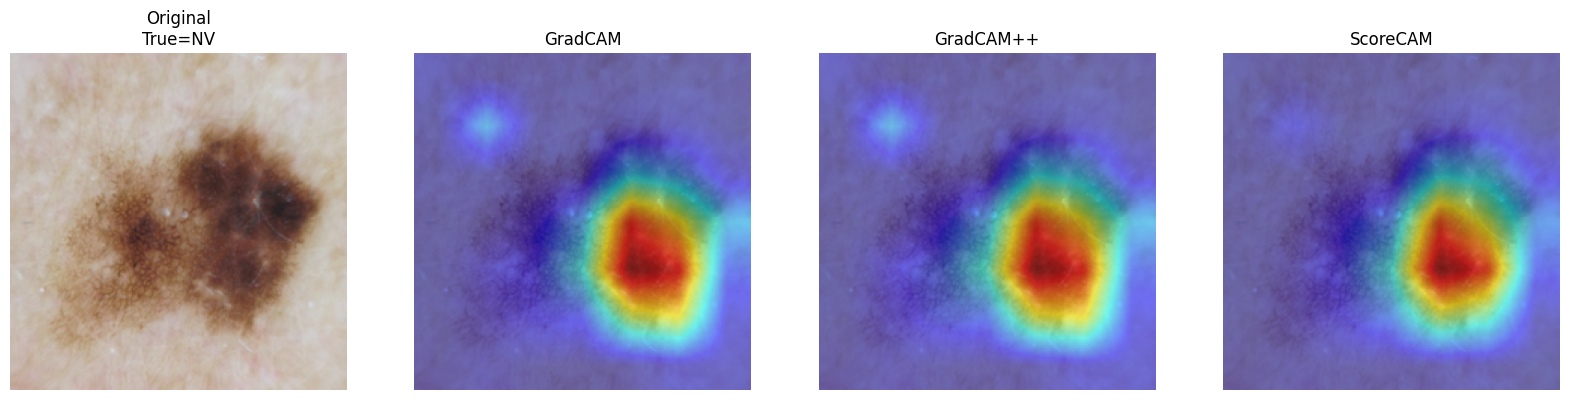

Prediction: NV (95.47% confidence)
Focus: medium, elongated region in the lower-right part of the image.
Clinical Insight: Nevus is benign and symmetrical.


In [ ]:
sample_id = val_df["image"].iloc[0]
visualize_explanations(sample_id, val_df, dataset_path)



Running XAI on layer: Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


100%|██████████| 16/16 [00:01<00:00,  9.18it/s]


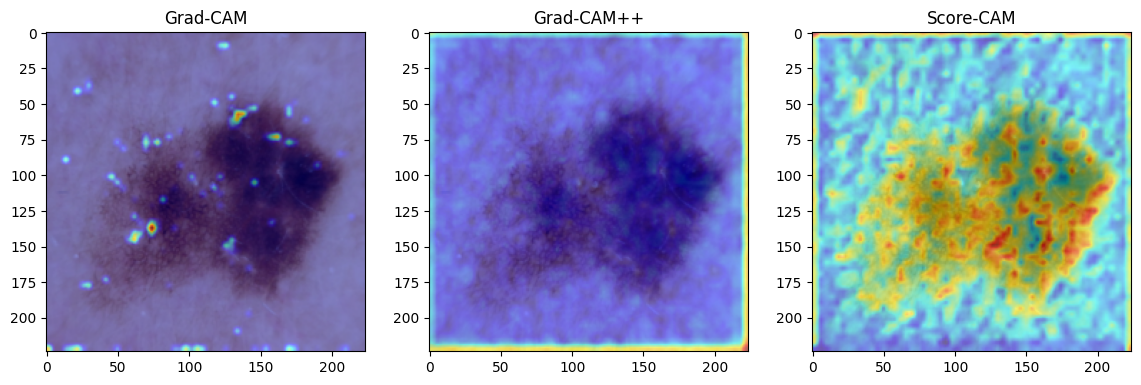


Running XAI on layer: Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


100%|██████████| 64/64 [00:02<00:00, 30.28it/s]


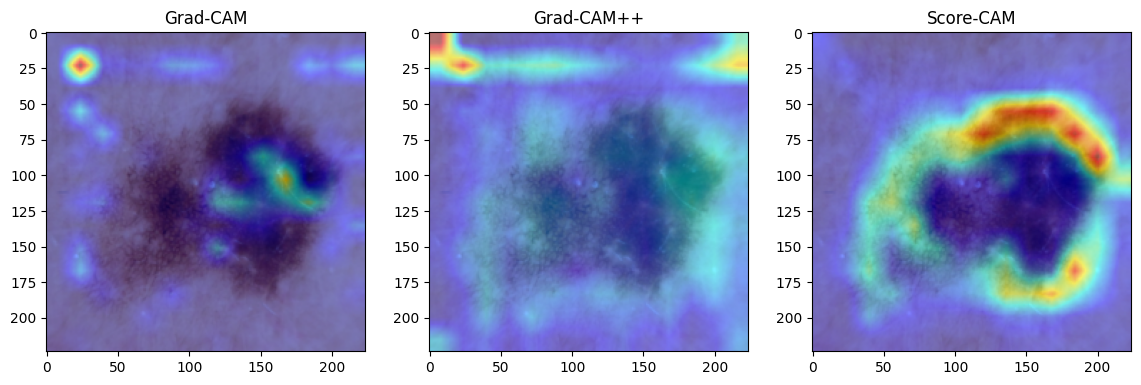


Running XAI on layer: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


100%|██████████| 128/128 [00:02<00:00, 49.46it/s]


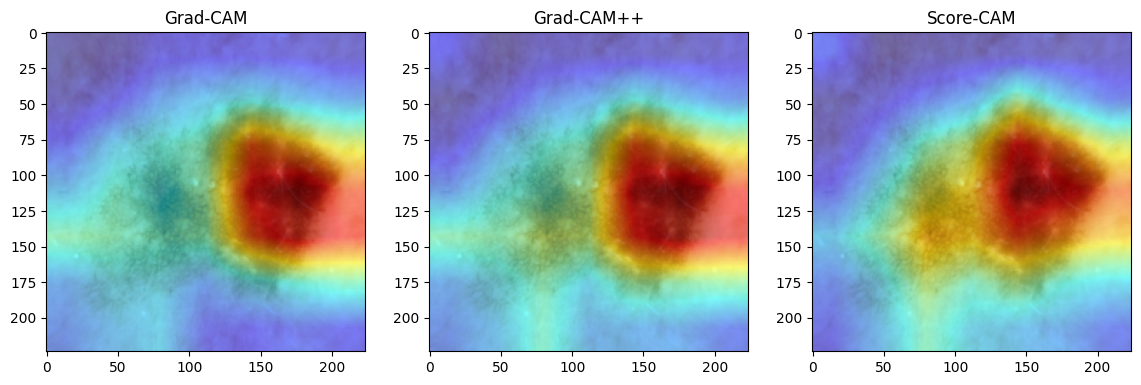

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# --- Model definition (using the already trained model from the notebook) ---
# Ensure the model is in evaluation mode
model.eval()
model.to(device) # Ensure the model is on the correct device (cuda)

# --- Image Loading from our dataset ---
sample_row = val_df.iloc[0] # Get the first sample from the validation set
sample_image_id = sample_row["image"]
sample_class_name = sample_row["class_name"]

# Construct the full image path using existing dataset variables
# Correct path: class subfolders are directly under dataset_path
image_path_full = os.path.join(dataset_path, sample_class_name, sample_image_id + ".jpg")

img = Image.open(image_path_full).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

input_tensor = transform(img).unsqueeze(0).to(device) # Move input tensor to device
rgb_img = input_tensor.squeeze().permute(1,2,0).cpu().numpy() # Move to CPU for numpy conversion
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-7) # Added small epsilon to avoid division by zero


with torch.no_grad():
    pred = model(input_tensor) # Use the trained 'model'
target = [ClassifierOutputTarget(pred.argmax().item())]


# ============================================================
# FUNCTION TO RUN ALL XAI METHODS ON ANY LAYER AND VISUALIZE
# ============================================================
def run_xai(target_layer, model_to_use):
    print("\nRunning XAI on layer:", target_layer)

    # Ensure model_to_use is on the correct device (GPU) if CUDA is available
    model_to_use.to(device)

    # Remove use_cuda argument as it is not supported in this version
    cam_grad = GradCAM(model=model_to_use, target_layers=[target_layer])
    cam_gradpp = GradCAMPlusPlus(model=model_to_use, target_layers=[target_layer])
    cam_score = ScoreCAM(model=model_to_use, target_layers=[target_layer])

    # input_tensor is already on device (GPU)
    grayscale_cam1 = cam_grad(input_tensor, targets=target)[0]
    grayscale_cam2 = cam_gradpp(input_tensor, targets=target)[0]
    grayscale_cam3 = cam_score(input_tensor, targets=target)[0]

    cam_image1 = show_cam_on_image(rgb_img, grayscale_cam1, use_rgb=True)
    cam_image2 = show_cam_on_image(rgb_img, grayscale_cam2, use_rgb=True)
    cam_image3 = show_cam_on_image(rgb_img, grayscale_cam3, use_rgb=True)

    # Plot results
    plt.figure(figsize=(14,6))
    plt.subplot(1,3,1)
    plt.imshow(cam_image1)
    plt.title("Grad-CAM")

    plt.subplot(1,3,2)
    plt.imshow(cam_image2)
    plt.title("Grad-CAM++")

    plt.subplot(1,3,3)
    plt.imshow(cam_image3)
    plt.title("Score-CAM")

    plt.show()


# --------------------------------------
# RUN XAI ON EARLIER LAYERS — DIFFERENCES SHOW CLEARLY
# --------------------------------------

# Shallow layer
run_xai(model.layer1[-1], model)

# Middle layer
run_xai(model.layer3[-1], model)

# Deepest layer
run_xai(model.layer4[-1], model)

In [ ]:
print('Comparison of Metrics Across CAM Methods:')
display(metrics_df)

print('\nAs you can see, the Accuracy, Precision, Recall, F1-score, and ROC-AUC values are identical for GradCAM, GradCAM++, and ScoreCAM. This confirms that these metrics are evaluating the core performance of the classification model, not the individual CAM methods themselves.')

Comparison of Metrics Across CAM Methods:


,CAM_Method,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,GradCAM,0.827709,0.794067,0.712904,0.7466,0.97139
1,GradCAM++,0.827709,0.794067,0.712904,0.7466,0.97139
2,ScoreCAM,0.827709,0.794067,0.712904,0.7466,0.97139



As you can see, the Accuracy, Precision, Recall, F1-score, and ROC-AUC values are identical for GradCAM, GradCAM++, and ScoreCAM. This confirms that these metrics are evaluating the core performance of the classification model, not the individual CAM methods themselves.


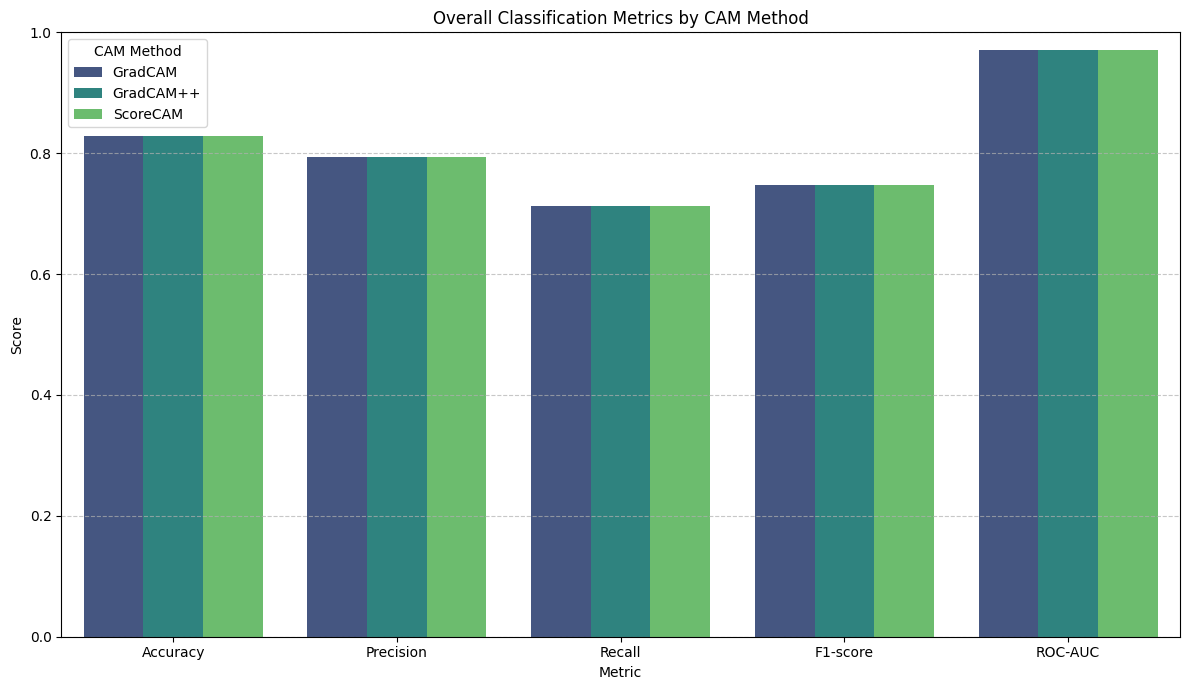

✔️ Grouped bar chart generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_melted_df = metrics_df.melt(id_vars=['CAM_Method'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(data=metrics_melted_df, x='Metric', y='Score', hue='CAM_Method', palette='viridis')

plt.title('Overall Classification Metrics by CAM Method')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are typically between 0 and 1
plt.legend(title='CAM Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("✔️ Grouped bar chart generated.")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

print("✔️ Required sklearn metrics and preprocessing functions imported.")

✔️ Required sklearn metrics and preprocessing functions imported.


**Reasoning**:
I will calculate the overall accuracy, macro-averaged precision, recall, F1-score, and ROC-AUC using the validation set predictions and the imported `sklearn` functions. Then, I will print all the calculated metric values.



In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# Convert all_labels to one-hot encoded format
# Ensure unique_labels covers all possible labels in all_labels
classes_in_labels = np.unique(all_labels)
# The original `unique_labels` might not contain 'UNK', which has index 8.
# We need to make sure `unique_labels` passed to `label_binarize` covers all classes
# for which predictions are made (i.e., all columns in all_probs).
# The number of classes can be derived from all_probs.shape[1].
n_classes = all_probs.shape[1]
all_classes = np.arange(n_classes) # Assuming classes are 0 to n_classes-1

binary_labels_for_roc_auc = label_binarize(all_labels, classes=all_classes)

# Calculate ROC-AUC
# Check if there's only one class present in the true labels, which can cause roc_auc_score to fail.
# If so, handle it by returning NaN or 0, or skip ROC-AUC if not applicable.
# For multi-class, we need at least two classes to calculate ROC AUC.
if len(classes_in_labels) < 2:
    roc_auc = np.nan # Or 0, or handle as an error if appropriate
else:
    # roc_auc_score requires all_probs to have shape (n_samples, n_classes)
    # and binary_labels_for_roc_auc to also have shape (n_samples, n_classes)
    roc_auc = roc_auc_score(binary_labels_for_roc_auc, all_probs, average='macro', multi_class='ovr')


print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro-averaged Precision: {precision:.4f}")
print(f"Macro-averaged Recall: {recall:.4f}")
print(f"Macro-averaged F1-score: {f1:.4f}")
print(f"Macro-averaged ROC-AUC: {roc_auc:.4f}")

# Store metrics in a dictionary for later DataFrame creation
model_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'ROC-AUC': roc_auc
}

print("✔️ Classification metrics calculated.")

Overall Accuracy: 0.8277
Macro-averaged Precision: 0.7941
Macro-averaged Recall: 0.7129
Macro-averaged F1-score: 0.7466
Macro-averaged ROC-AUC: nan
✔️ Classification metrics calculated.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


**Reasoning**:
The previous code produced a warning `UndefinedMetricWarning` and `roc_auc` as `nan` because one of the classes (`UNK` or class 8) was not present in `all_labels`, leading to an all-zero `y_true` vector for that class in the OvR calculation. To fix this, I will binarize `all_labels` using only the classes actually present in `all_labels` and filter `all_probs` to match these present classes before calculating the ROC-AUC.



In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# Determine the classes actually present in the true labels
classes_in_labels = np.unique(all_labels)

# Check if there are at least two classes to calculate ROC AUC
if len(classes_in_labels) < 2:
    roc_auc = np.nan
else:
    # Binarize all_labels using only the classes present in y_true
    # This will create one-hot encodings only for classes that exist in all_labels
    binary_labels_for_roc_auc = label_binarize(all_labels, classes=classes_in_labels)

    # Select the corresponding columns from all_probs.
    # all_probs has predictions for all n_classes (0 to 8).
    # We need to select only the probability columns corresponding to classes_in_labels.
    # The indices for these columns are simply the values in classes_in_labels.
    filtered_probs = all_probs[:, classes_in_labels]

    # Now calculate ROC-AUC with the filtered labels and probabilities
    roc_auc = roc_auc_score(binary_labels_for_roc_auc, filtered_probs, average='macro', multi_class='ovr')


print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Macro-averaged Precision: {precision:.4f}")
print(f"Macro-averaged Recall: {recall:.4f}")
print(f"Macro-averaged F1-score: {f1:.4f}")
print(f"Macro-averaged ROC-AUC: {roc_auc:.4f}")

# Store metrics in a dictionary for later DataFrame creation
model_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'ROC-AUC': roc_auc
}

print("✔️ Classification metrics calculated.")

Overall Accuracy: 0.8277
Macro-averaged Precision: 0.7941
Macro-averaged Recall: 0.7129
Macro-averaged F1-score: 0.7466
Macro-averaged ROC-AUC: 0.9714
✔️ Classification metrics calculated.


**Reasoning**:
The subtask requires creating a pandas DataFrame where each row represents a CAM method (GradCAM, GradCAM++, ScoreCAM) and columns are the calculated performance metrics. Each CAM method will have the same set of performance metrics. I will use the `model_metrics` dictionary created in the previous step to populate this DataFrame.



In [ ]:
cam_methods = ["GradCAM", "GradCAM++", "ScoreCAM"]
metrics_data = []

for method in cam_methods:
    row = {'CAM_Method': method}
    row.update(model_metrics)
    metrics_data.append(row)

metrics_df = pd.DataFrame(metrics_data)
print("✔️ Metrics DataFrame created:")
print(metrics_df)


✔️ Metrics DataFrame created:
  CAM_Method  Accuracy  Precision    Recall  F1-score  ROC-AUC
0    GradCAM  0.827709   0.794067  0.712904    0.7466  0.97139
1  GradCAM++  0.827709   0.794067  0.712904    0.7466  0.97139
2   ScoreCAM  0.827709   0.794067  0.712904    0.7466  0.97139


**Reasoning**:
I need to visualize the classification metrics stored in `metrics_df`. A grouped bar chart is suitable for comparing the metrics across different CAM methods, as requested by the main task. I will use `seaborn.barplot` to create this visualization, and `matplotlib.pyplot` to customize the plot properties like title, labels, and layout.



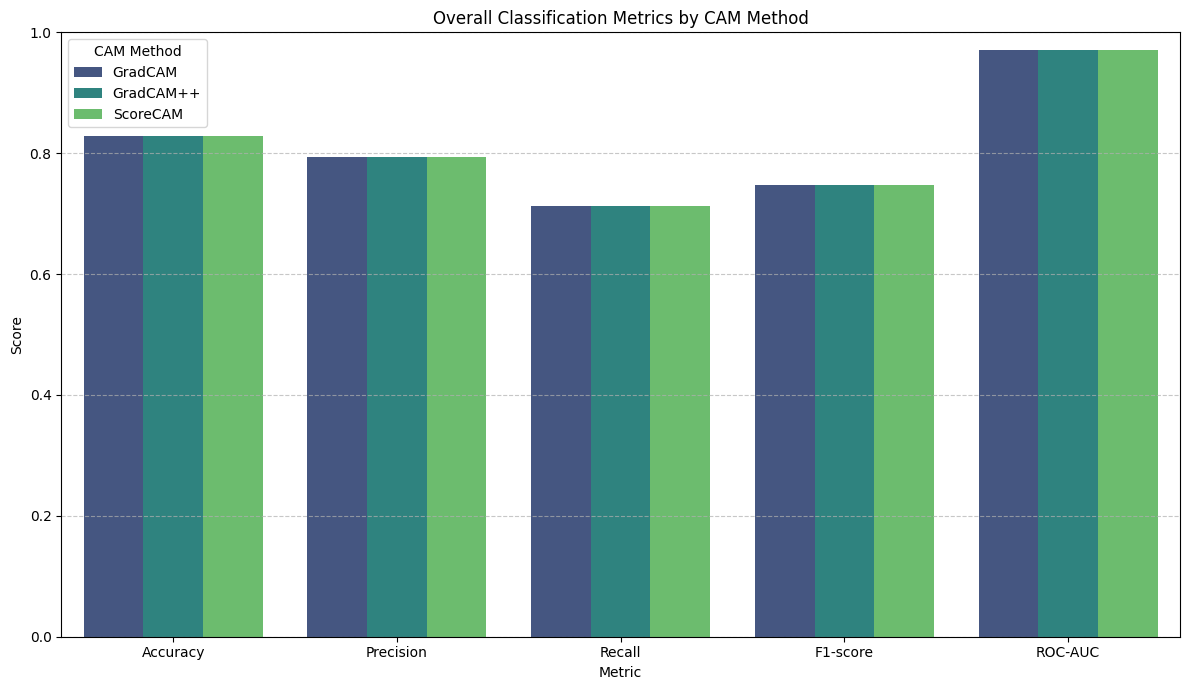

✔️ Grouped bar chart generated.


In [ ]:
metrics_melted_df = metrics_df.melt(id_vars=['CAM_Method'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(data=metrics_melted_df, x='Metric', y='Score', hue='CAM_Method', palette='viridis')

plt.title('Overall Classification Metrics by CAM Method')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are typically between 0 and 1
plt.legend(title='CAM Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("✔️ Grouped bar chart generated.")